# Purpose
My purpose is to use transfert Learning for detecting plant diseases. For achieving this , I opt for MobileNet

# Why?
It presents some good performances on mobile phone by decreasing FLOPS while keeping good performances

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation

from tensorflow.keras.applications.efficientnet import decode_predictions


# Loading
Lets start by loading our project. I will use image_load_dataset for loading my images.Its parameters are:
* directory
* shuffle
* image_size :the format of our image. It can be (64,64) or (224,224)
* validation_split
* subset: It can be  training , validation or both
* seed:for avoiding randomness

In [2]:
DATASETDIR = "dataset/"
BatchSize = 32
IMAGESIZE = (160,160)

train = image_dataset_from_directory(
    DATASETDIR+'trainVal',
    shuffle=True,
    image_size=IMAGESIZE,
    subset='training',
    validation_split=0.2,
    seed=42
    
)
validation = image_dataset_from_directory(
    DATASETDIR+'trainVal',
    shuffle=True,
    image_size=IMAGESIZE,
    subset='validation',
    validation_split=0.2,
    seed=42
    
)
test = image_dataset_from_directory(
    DATASETDIR+'test',
    shuffle=True,
    image_size=IMAGESIZE,
    seed=42
    
)

Found 70297 files belonging to 38 classes.
Using 56238 files for training.
Found 70297 files belonging to 38 classes.
Using 14059 files for validation.
Found 1001 files belonging to 2 classes.


## Lets differents classes

In [3]:
classNames = train.class_names
print(classNames)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

## Lets visualize our dataset
You can change the value in train.take(16) for see another subset

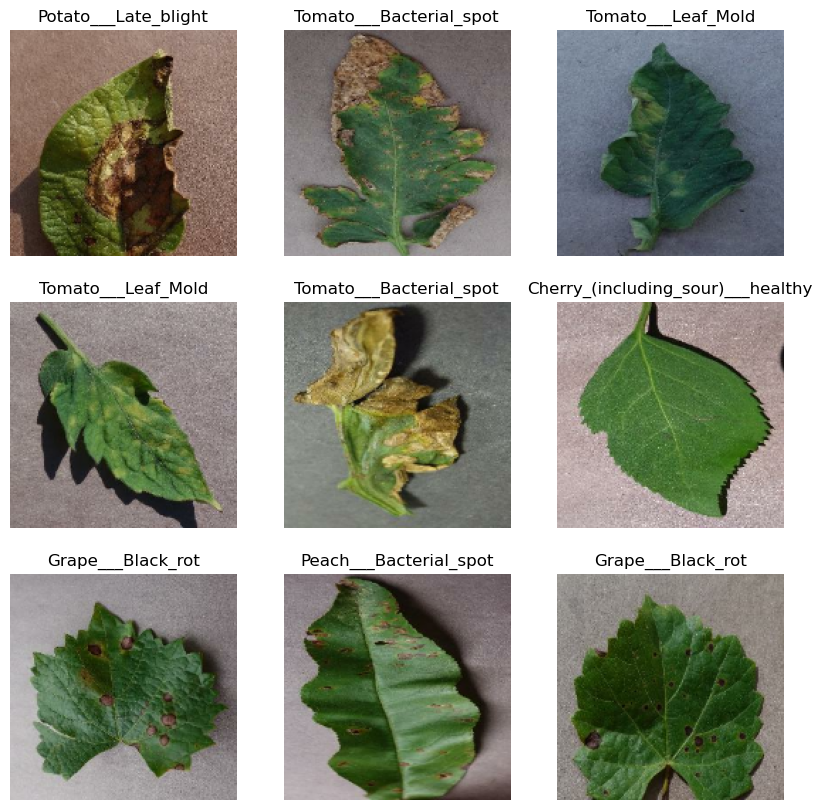

In [4]:
plt.figure(figsize=(10, 10))

for images, labels in train.take(16):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")

# Preprocessing
I dont enough data for my transfert learning. I will generate some new by flipping or rotating

In [5]:
def augmentData():
    dataAugmentation = tf.keras.Sequential([
        RandomFlip('horizontal'),
        RandomRotation(0.3)
    ])

    return dataAugmentation

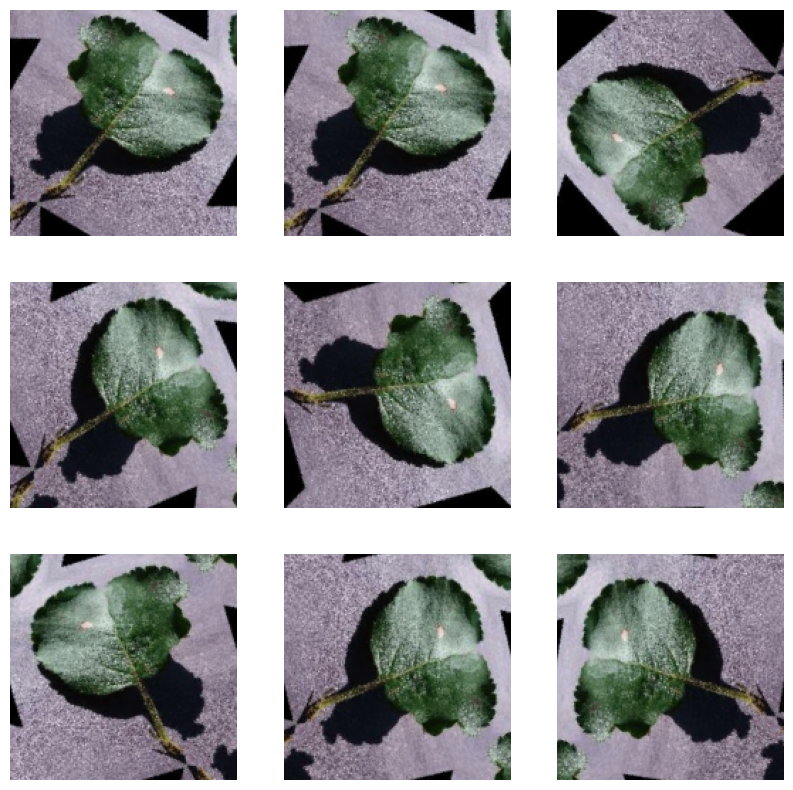

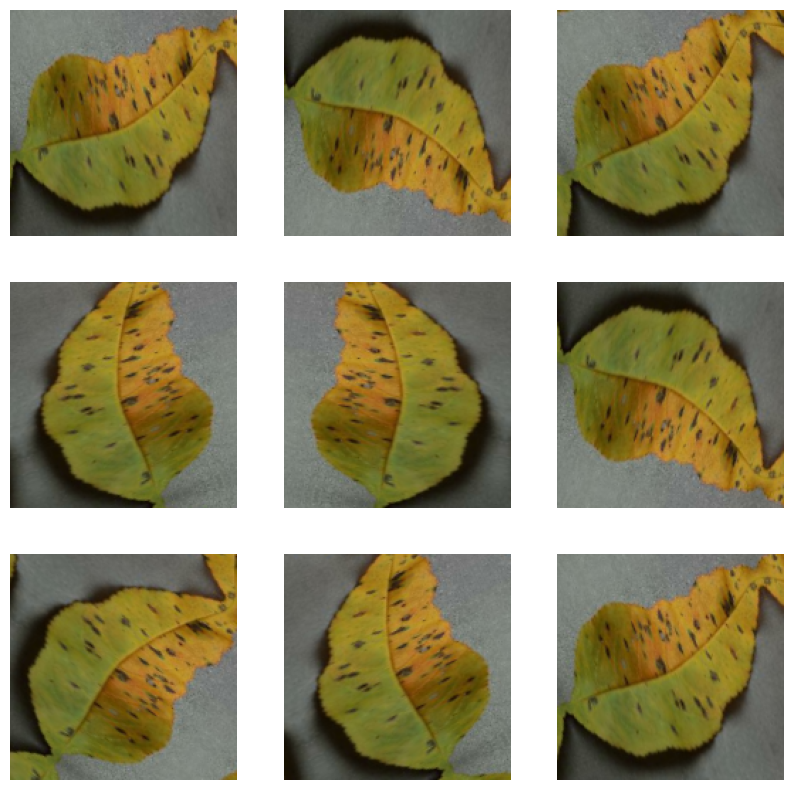

In [6]:
dataAugmentation = augmentData()

for image, labels in train.take(2):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmentedImage = dataAugmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmentedImage[0] / 255)
        plt.axis('off')

# Lets setup effiscientnet

In [7]:
preprocessInput = tf.keras.applications.mobilenet.preprocess_input

# I download weight of effiscient for applying a transfert learning

In [8]:
IMG_SHAPE = IMAGESIZE + (3,)

BaseModel = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights="imagenet")

In [9]:
BaseModel.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 80, 80, 32)        │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 80, 80, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 80, 80, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 80, 80, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 80, 80, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 80, 80, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 80, 80, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 80, 80, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 80, 80, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 80, 80, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 80, 80, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 81, 81, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 40, 40, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [10]:
ImageBatch , labelBatch = next(iter(train))
featureBatch = BaseModel(ImageBatch)
print(featureBatch.shape)

(32, 1000)


In [11]:
labelBatch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([10, 34,  3, 19, 29, 12, 29, 34,  7, 11,  8, 19, 20, 11,  7,  5, 27,
       20, 23,  0, 16, 21, 31, 24,  7,  6,  0, 17, 31,  1, 32, 36],
      dtype=int32)>

In [12]:
BaseModel.trainable = False
imageVar = tf.Variable(preprocessInput(ImageBatch))
pred = BaseModel(imageVar)

decodedPredictions = decode_predictions(pred.numpy(), top=2)

In [13]:
def DiagnosisModel(dataAugmentation=augmentData()):
    InputShape = (160,160,3)

    BaseModel = tf.keras.applications.MobileNetV2(input_shape=InputShape,
                                                   include_top=False,
                                                   weights="imagenet")
    BaseModel.trainable = False

    inputs = tf.keras.Input(shape=InputShape)
    x = dataAugmentation(inputs)
    x = preprocessInput(x)
    x = BaseModel(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [14]:
modelDiagnosis = DiagnosisModel(dataAugmentation)

# Now we can compile our model

In [15]:
baseLearningRate = 0.001

modelDiagnosis.compile(
    optimizer = tf.keras.optimizers.Adam(baseLearningRate),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [16]:
epochs = 5
history = modelDiagnosis.fit(train, validation_data=validation, epochs=epochs)

Epoch 1/5


C:\Users\LENOVO T14s\AppData\Roaming\Python\Python313\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1758/1758 ━━━━━━━━━━━━━━━━━━━━ 676s 381ms/step - accuracy: 0.0277 - loss: 2.2040e-06 - val_accuracy: 0.0312 - val_loss: 2.1773e-06
Epoch 2/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 630s 359ms/step - accuracy: 0.0272 - loss: 2.2040e-06 - val_accuracy: 0.0312 - val_loss: 2.1773e-06
Epoch 3/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 664s 377ms/step - accuracy: 0.0273 - loss: 2.2040e-06 - val_accuracy: 0.0312 - val_loss: 2.1773e-06
Epoch 4/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 756s 430ms/step - accuracy: 0.0263 - loss: 2.2040e-06 - val_accuracy: 0.0312 - val_loss: 2.1773e-06
Epoch 5/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 5529s 3s/step - accuracy: 0.0274 - loss: 2.2040e-06 - val_accuracy: 0.0312 - val_loss: 2.1773e-06


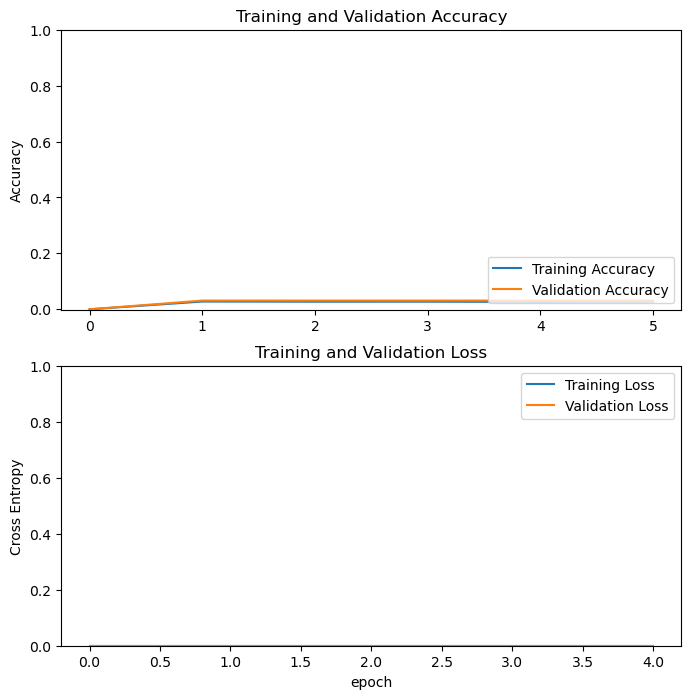

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Now we can fine-tune

In [ ]:
# We select the fourth layer for retraining it. It is a selective PEFT
BaseModel = modelDiagnosis.layers[4] 
BaseModel.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 120


for layer in BaseModel.layers[:fine_tune_at]:
    layer.trainable = False
    
loss_function=tf.python.keras.losses.CategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(0.1 * baseLearningRate)

metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

NameError: name 'base_model' is not defined

In [ ]:
finetuneEpochs = 5
totalEpochs =  epochs + finetuneEpochs

historyFine = model2.fit(train_dataset,
                         epochs=totalEpochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


In [ ]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()